# Deep ensemble for uncertainty estimation

https://medium.com/@albertoarrigoni/paper-review-code-deep-ensembles-nips-2017-c5859070b8ce
https://github.com/vvanirudh/deep-ensembles-uncertainty/blob/master/model.py
https://github.com/muupan/deep-ensemble-uncertainty/blob/master/train_ensemble.ipynb


## Import & preprocess the data

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

module_path = os.path.abspath(os.path.join('../..'))

sys.path.insert(1, module_path + '/src')

from sklearn import preprocessing
from keras.utils import np_utils
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sktime.utils.data_processing import from_nested_to_2d_array

In [2]:
X_train, y_train_ = load_from_tsfile_to_dataframe(module_path + '/data/ts_files/minimal_dataset_2class_TRAIN.ts')
X_test, y_test_ = load_from_tsfile_to_dataframe(module_path + '/data/ts_files/minimal_dataset_2class_TEST.ts')
X_val, y_val_ = load_from_tsfile_to_dataframe(module_path + '/data/ts_files/minimal_dataset_2class_VAL.ts')

X_train, y_train_= shuffle(X_train, y_train_, random_state = 42)

X_train, X_test, X_val = from_nested_to_2d_array(X_train), from_nested_to_2d_array(X_test), from_nested_to_2d_array(X_val)

cols = np.arange(len(X_test.columns))
X_train.columns, X_test.columns, X_val.columns = cols, cols, cols

y_train_, y_test_, y_val_ = pd.Series(y_train_), pd.Series(y_test_), pd.Series(y_val_)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_val = X_val.to_numpy()

X_train, y_train_= shuffle(X_train, y_train_, random_state = 42)
X_val, y_val_= shuffle(X_val, y_val_, random_state = 42)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

le = preprocessing.LabelEncoder()

le.fit(y_train_)
num_classes = len(le.classes_)
y_train = le.transform(y_train_)
y_test = le.transform(y_test_)
y_val = le.transform(y_val_)

y_train = np_utils.to_categorical(y_train, num_classes = num_classes)
y_test = np_utils.to_categorical(y_test, num_classes = num_classes)
y_val = np_utils.to_categorical(y_val, num_classes = num_classes)

## Modified Layers in NN

A proper scoring rule needs to be used. In this case the final layer of the neural network should output the mean and the variance, to take into account the predictive uncertainty. 

The custom loss function treats the observed value as a sample from a Gaussian distribution. Using the predicted mean and variance the negative log loss is calculated as the custom loss function

In [3]:
from tensorflow import math
from keras import backend as K
from keras.layers import Input, Dense, Layer, Dropout, Conv1D, Flatten, MaxPooling1D
from keras.models import Model
from keras.initializers import glorot_normal
import numpy as np


def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        fir = 0.5*math.log(sigma)
        sec = 0.5*math.divide(math.square(y_true - y_pred), sigma)
        res = math.reduce_mean(fir + sec, axis = -1) + 1e-6
        return res
    return gaussian_loss



class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(1500, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(1500, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        #print(self.kernel_1.shape)
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
       
        return [output_mu, output_sig_pos]
    
    def compute_output_shape(self, input_shape):
        
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]


## Single network

In [8]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

input_shape=(X_train.shape[1], 1)

inputs = Input(shape=input_shape)
x = Conv1D(filters=50, kernel_size=6, activation='relu', input_shape=input_shape)(inputs)
x = MaxPooling1D(pool_size=50)(x)
x = Conv1D(filters=50, kernel_size=6, activation='relu' ,  padding="same")(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(1500, activation='relu')(x)
x = Dropout(0.25)(x)
mu, sigma = GaussianLayer(num_classes, name='main_output')(x)
model = Model(inputs, mu)
model.compile(loss=custom_loss(sigma), optimizer='adam')
#model.fit(X_train, y_train, epochs=10, batch_size = 10)
model.fit(X_train, y_train, epochs=30, batch_size = 10, verbose = 1, validation_data = (X_val, y_val))

Train on 867 samples, validate on 295 samples
Epoch 1/30
867/867 [==============================] - 3s 3ms/sample - loss: -0.1286 - val_loss: -0.1956
Epoch 2/30
867/867 [==============================] - 2s 3ms/sample - loss: -0.1870 - val_loss: -0.1842
Epoch 3/30
630/867 [====================>.........] - ETA: 0s - loss: -0.1619

KeyboardInterrupt: 

## Ensemble network

In [9]:
layer_name = 'main_output' # Where to extract the output from
#get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)

def create_trained_network(X_train, y_train, X_val, y_val):
    input_shape=(X_train.shape[1], 1)

    inputs = Input(shape=input_shape)
    x = Conv1D(filters=50, kernel_size=6, activation='relu', input_shape=input_shape)(inputs)
    x = MaxPooling1D(pool_size=50)(x)
    x = Conv1D(filters=50, kernel_size=6, activation='relu' ,  padding="same")(x)
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(1500, activation='relu')(x)
    x = Dropout(0.25)(x)
    mu, sigma = GaussianLayer(num_classes, name='main_output')(x)
    model = Model(inputs, mu)
    model.compile(loss=custom_loss(sigma), optimizer='adam')
    model.fit(X_train, y_train, epochs=30, batch_size = 10, verbose = 0, validation_data = (X_val, y_val))
    layer_name = 'main_output' # Where to extract the output from
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)
    return get_intermediate



prediction_fns = []
for i in range(10):
    prediction_fns.append(create_trained_network(X_train, y_train, X_val, y_val))
    
preds, sigmas = [], []
for i in range(10):
    pred = prediction_fns[i](np.array([X_test]))[0]
    sigma = prediction_fns[i](np.array([X_test]))[1]
    
    preds.append(pred)
    sigmas.append(sigma)
    
preds = np.array(preds)
sigmas = np.array(sigmas)

In [11]:
prediction_fns = []
for i in range(10):
    prediction_fns.append(create_trained_network(X_train, y_train, X_val, y_val))

InvalidArgumentError: input must be 4-dimensional[1,237,1,4000,1]
	 [[{{node conv1d_28/conv1d}}]]

In [18]:
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

In [21]:
len(X_test)

237

In [40]:
preds, sigmas = [], [] 
for j in range(len(X_test)):
    preds_curr, sigmas_curr = [], []
    for i in range(10):
        preds_curr.append(prediction_fns[i](np.array([X_test[j]]))[0])
        sigmas_curr.append(prediction_fns[i](np.array([X_test[j]]))[1])

    
    preds_curr = np.array(preds_curr)
    sigmas_curr = np.array(sigmas_curr)
    #print(np.mean(preds_curr, axis = 0))
    #sigmas.append(np.sqrt(np.mean(sigmas_curr + np.square(preds_curr), axis = 0) - np.square(preds_curr)))
    preds.append(np.mean(preds_curr, axis = 0))

In [16]:
import tensorflow as tf


def create_trained_network_with_adv(X_train, y_train):
    input_shape=(X_train.shape[1], 1)

    inputs = Input(shape=input_shape)
    outputs = Input(shape=input_shape)
    x = Conv1D(filters=50, kernel_size=6, activation='relu', input_shape=input_shape)(inputs)
    x = MaxPooling1D(pool_size=50)(x)
    x = Conv1D(filters=50, kernel_size=6, activation='relu' ,  padding="same")(x)
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(1500, activation='relu')(x)
    x = Dropout(0.25)(x)
    mu, sigma = GaussianLayer(num_classes, name='main_output')(x)
    model = Model(inputs, mu)
    model.compile(loss=custom_loss(sigma), optimizer='adam')
    model.fit(X_train, y_train, epochs=1, batch_size = 10)
    
    def gaussian_loss(y_true, y_pred, sigma):
        """
        Util function used to derive gradients w.r.t. to input data (for adversarial examples generation)
        """
        return math.reduce_mean(0.5*math.log(sigma) + 0.5*math.divide(math.square(y_true - y_pred), sigma)) + 1e-6
    
    
    #### ADVERSARIAL TRAINING EXAMPLES GENERATION
    loss_calc = gaussian_loss(outputs, mu, sigma)
    print('loss',loss_calc)
    loss_gradients = tf.gradients(loss_calc, inputs)
    print('gradient', loss_gradients)
    gr_sign = math.sign(loss_gradients)
    print('sign', gr_sign)
    adversarial_input_data = tf.add(inputs, 0.4 * gr_sign)
    
    print(adversarial_input_data)
    ####
    sess = tf.compat.v1.Session()
    init_op = tf.compat.v1.global_variables_initializer()
    sess.run(init_op)
    
    adversarial_input_data = sess.run(adversarial_input_data, feed_dict={inputs: X_train, outputs: y_train})[0]
    print(adversarial_input_data)
    augmented_train_x = np.concatenate([X_train, adversarial_input_data.reshape(X_train.shape[0], 1)])
    augmented_train_y = np.concatenate([y_train, y_train])
    
    model.fit(augmented_train_x, augmented_train_y, epochs=1, verbose=0)
    
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)
    
    return get_intermediate

In [17]:
prediction_fns = []
for i in range(2):
    prediction_fns.append(create_trained_network_with_adv(X_train, y_train))

Train on 867 samples
867/867 [==============================] - 3s 4ms/sample - loss: -0.0903
loss Tensor("add_4:0", shape=(), dtype=float32)
gradient [<tf.Tensor 'gradients_1/conv1d_30/conv1d/ExpandDims_grad/Reshape:0' shape=(None, 4000, 1) dtype=float32>]
sign Tensor("Sign_1:0", shape=(1, None, 4000, 1), dtype=float32)
Tensor("Add_5:0", shape=(1, None, 4000, 1), dtype=float32)


ValueError: Cannot feed value of shape (867, 2) for Tensor 'input_15:0', which has shape '(None, 4000, 1)'

# Testing deep ensemble on test data

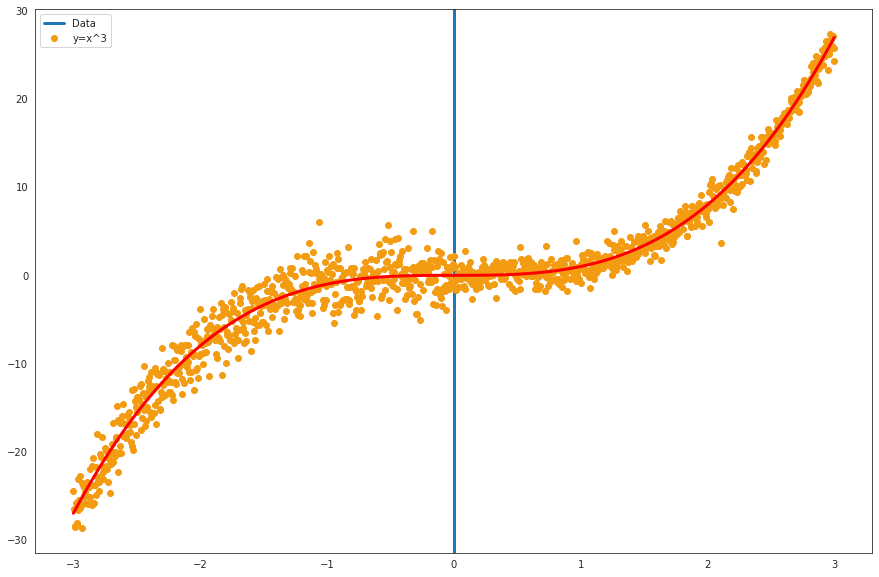

In [18]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("white")
test_ratio = 0.1
data_range = 3
data_step = 0.005
data_sigma1 = 2
data_sigma2 = 1
def pow_fun(x):
    return np.power(x, 3)
data_x = np.arange(-data_range, data_range + data_step, data_step)
data_x = np.reshape(data_x, [data_x.shape[0], 1])
data_y = np.zeros([data_x.shape[0], 1])
data_y_true = np.zeros([data_x.shape[0], 1])
for i in range(data_x.shape[0]):
    if (data_x[i,0] < 0): 
        data_y[i, 0] = pow_fun(data_x[i,0]) + np.random.normal(0, data_sigma1)
    else:
        data_y[i, 0] = pow_fun(data_x[i,0]) + np.random.normal(0, data_sigma2)
        
    data_y_true[i, 0] = pow_fun(data_x[i,0])
    
num_train_data = int(data_x.shape[0] * (1 - test_ratio))
num_test_data  = data_x.shape[0] - num_train_data
train_x = data_x[:num_train_data, :]
train_y = data_y[:num_train_data, :]
test_x  = data_x[num_train_data:, :]
test_y  = data_y[num_train_data:, :]
plt.rcParams['figure.figsize'] = [15, 10]
plt.axvline(x=0, linewidth=3)
plt.plot(data_x, data_y, '.', markersize=12, color='#F39C12')
plt.plot(data_x, data_y_true, 'r', linewidth=3)
plt.legend(['Data', 'y=x^3'], loc = 'best')
# plt.title('y = x^3 where $\epsilon$ ~ N(0, 3^2) and N(0, 1^2)')
plt.show()

In [19]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense, Layer, Dropout
from keras.models import Model
from keras.initializers import glorot_normal
import numpy as np
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return math.reduce_mean(0.5*math.log(sigma) + 0.5*math.divide(math.square(y_true - y_pred), sigma)) + 1e-6
    return gaussian_loss
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(30, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(30, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [20]:
# Multiple networks with adversarial examples
def create_trained_network_with_adv(train_x, train_y):
    inputs = Input(shape=(1,))
    outputs = Input(shape=(1,))
    x = Dense(10, activation='relu')(inputs)
    x = Dense(6, activation='relu')(x)
    x = Dense(30, activation='relu')(x)
    mu, sigma = GaussianLayer(1, name='main_output')(x)
    model = Model(inputs, mu)
    model.compile(loss=custom_loss(sigma), optimizer='adam')
    model.fit(train_x, train_y, epochs=400, verbose=0)
    def gaussian_loss(y_true, y_pred, sigma):
        """
        Util function used to derive gradients w.r.t. to input data (for adversarial examples generation)
        """
        return math.reduce_mean(0.5*math.log(sigma) + 0.5*math.divide(math.square(y_true - y_pred), sigma)) + 1e-6
    #### ADVERSARIAL TRAINING EXAMPLES GENERATION
    loss_calc = gaussian_loss(outputs, mu, sigma)
    print(loss_calc)
    loss_gradients = tf.gradients(loss_calc, inputs)
    print('loss gradients' , loss_gradients)
    gr_sign = tf.sign(loss_gradients)
    print('gradient sign', gr_sign)
    adversarial_input_data = tf.add(inputs, 0.4 * gr_sign)
    print(adversarial_input_data)
    ####
    sess = tf.Session()
    init_op = tf.global_variables_initializer()
    
    sess.run(init_op)
    adversarial_input_data = sess.run([adversarial_input_data], feed_dict={inputs: train_x, outputs: train_y})[0]
    print(adversarial_input_data.shape)
    
    
    augmented_train_x = np.concatenate([train_x, adversarial_input_data.reshape(train_x.shape[0], 1)])
    print(augmented_train_x)
    
    augmented_train_y = np.concatenate([train_y, train_y])
    model.fit(augmented_train_x, augmented_train_y, epochs=400, verbose=0)
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)
    return get_intermediate

In [52]:
train_x.shape

(1080, 1)

In [21]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

layer_name = 'main_output' # Where to extract the output from
#get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)

prediction_fns = []
for i in range(10):
    prediction_fns.append(create_trained_network_with_adv(train_x, train_y))

Instructions for updating:
non-resource variables are not supported in the long term
Tensor("add_7:0", shape=(), dtype=float32)
loss gradients [<tf.Tensor 'gradients_2/dense_16/MatMul_grad/MatMul:0' shape=(?, 1) dtype=float32>]
gradient sign Tensor("Sign_2:0", shape=(1, ?, 1), dtype=float32)
Tensor("Add_8:0", shape=(1, ?, 1), dtype=float32)
(1, 1080, 1)
[[-3.        ]
 [-2.995     ]
 [-2.99      ]
 ...
 [ 2.78500009]
 [ 2.7900002 ]
 [ 2.79500008]]


KeyboardInterrupt: 

In [ ]:
# Plot test with multiple networks
x_ax = np.linspace(-6, 6, num=200)
preds, sigmas = [], []
for j in range(len(x_ax)):
    
    mu_sigma = [(prediction_fns[i]([[np.array([x_ax[j]])]])[0][0][0], \
                prediction_fns[i]([[np.array([x_ax[j]])]])[1][0][0]) \
                for i in range(len(prediction_fns))]
    out_mus = [i for i,j in mu_sigma]
    out_mu = np.mean(out_mus)
    out_sigmas = [j for i,j in mu_sigma]
    out_sigma = np.sqrt(np.mean(out_sigmas + np.square(out_mus)) - np.square(out_mu))
    preds.append(out_mu.reshape(1,)[0])
    sigmas.append(out_sigma.reshape(1,)[0])
plt.figure(1, figsize=(15, 9))
plt.plot([i for i in x_ax], [i for i in preds], 'b', linewidth=3)
upper = [i+k for i,k in zip(preds, sigmas)]
lower = [i-k for i,k in zip(preds, sigmas)]
plt.fill_between(x_ax, upper, lower, color="orange", alpha=0.4)
plt.plot([i for i in x_ax], [pow_fun(i) for i in x_ax], 'y', linewidth = 2)
plt.ylim(-75, 75)
plt.title('Fitting x^3')